# Homework 4 (34 pts)

## Overview
This homework assignment will focus on exploring the spatial characteristics of Airbnb listings in Manhattan, New York City. By practicing K-means and DBSCAN clustering, you will deepen your understanding of this method and how it can be applied in empirical studies.


## 1. Read and Clean Data
### 1.1 Read and Clean Census Tract Data
Retrieving the census tract data follows the same process in Homework 2 so **ct** geodataframe is prepared for you.

In [2]:
# import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import matplotlib.pyplot as plt
# from shapely.geometry import Point
%matplotlib inline
# import cenpy
from pysal.lib import weights

from shapely.geometry import shape

ct = pd.read_json("https://data.cityofnewyork.us/resource/63ge-mke6.json?$where=BoroName='Manhattan'")
ct['the_geom'] = ct['the_geom'].apply(shape)
ct = gpd.GeoDataFrame(ct, geometry='the_geom').set_crs(epsg = 4326)
ct.info()

c:\Users\desai\miniforge3\envs\crp4680\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 310 entries, 0 to 309
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   the_geom    310 non-null    geometry
 1   ctlabel     310 non-null    float64 
 2   borocode    310 non-null    int64   
 3   boroname    310 non-null    object  
 4   ct2020      310 non-null    int64   
 5   boroct2020  310 non-null    int64   
 6   ntaname     310 non-null    object  
 7   nta2020     310 non-null    object  
 8   cdta2020    310 non-null    object  
 9   cdtaname    310 non-null    object  
 10  geoid       310 non-null    int64   
 11  shape_leng  310 non-null    float64 
 12  shape_area  310 non-null    float64 
dtypes: float64(3), geometry(1), int64(4), object(5)
memory usage: 33.9+ KB


### 1.2 Read and Clean Airbnb Listing Data
The Airbnb listing data is also the same as Homework 2 so the geodataframe **listing** is prepared too.

In [3]:
listing_raw = pd.read_csv('http://data.insideairbnb.com/united-states/ny/new-york-city/2024-02-06/data/listings.csv.gz')
listing_raw.price = listing_raw.price.replace('[\$,]', '', regex=True).astype(float)
listing_g = gpd.GeoDataFrame(listing_raw, 
                             geometry = gpd.points_from_xy(listing_raw.longitude, 
                                                           listing_raw.latitude)).set_crs(epsg = 4326)
listing = gpd.tools.sjoin(listing_g, ct[['geoid', 'boroname', 'the_geom']], 
                          predicate="within", how='inner')
listing.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 17160 entries, 7 to 39201
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   id                                            17160 non-null  int64   
 1   listing_url                                   17160 non-null  object  
 2   scrape_id                                     17160 non-null  int64   
 3   last_scraped                                  17160 non-null  object  
 4   source                                        17160 non-null  object  
 5   name                                          17160 non-null  object  
 6   description                                   16786 non-null  object  
 7   neighborhood_overview                         9735 non-null   object  
 8   picture_url                                   17160 non-null  object  
 9   host_id                                       1

## 2. K-means Clustering
### 2.1 The Built-in K-means Clustering (16 pts)
You will use KMeans module from sklearn to find the Airbnb listing clusters based solely on the listing locations. Recall the in-class example: to prepare the proper input for KMeans function, what should be *X*? Write your code below to create *X*. (2 pts)

In [47]:
# Need to standardize x and y since we are clustering based on location
from sklearn.preprocessing import RobustScaler, robust_scale

cluster_variables = ["longitude", "latitude"]
listing_small = listing[cluster_variables]
scaler = RobustScaler().fit(listing_small)

listing_scaled = scaler.transform(listing_small)

After correctly specifying X, use the KMeans module to quickly identify the clusters. Use `random` initialization, run `100` times of K-means algorithm around each centroid and specify `n_clusters` as 10 (2 pts)

Hint: You can refer to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) provided to learn how to add these parameters.

In [48]:
# insert your code here
from sklearn.cluster import KMeans
kmeans10 = KMeans(n_clusters=10, init='random', n_init=100)
# k10cls = kmeans10.fit(scalerLatitude.transform(listing_small))
k10_cls = kmeans10.fit(listing_scaled)

Create a plot to display your clustering results. Include the following:
- Clustered listing points, with marker size as 5. (2 pts)
- Centroids, with marker size as 10. (2 pts)
- Colored NTAs, with a grey edge color and 40% transparency. (2 pts) 

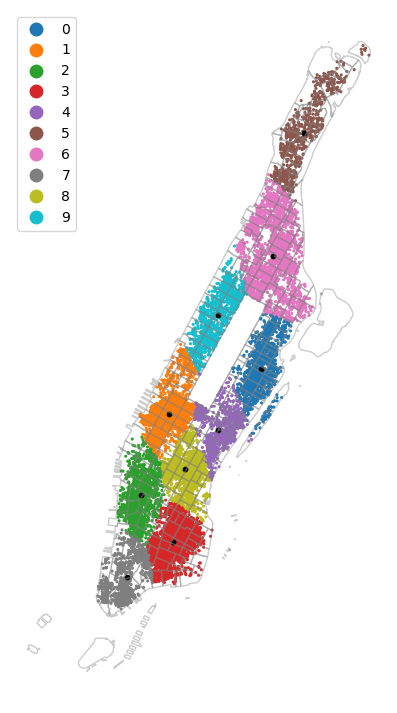

In [65]:
# insert cluster labels back into geodataframe
listing["k10cls"] = k10cls.labels_

# Create a GeoDataFrame for cluster centroids
cluster_centroids_unscaled = scaler.inverse_transform(k10_cls.cluster_centers_)
centroid_df = gpd.GeoDataFrame(geometry=gpd.points_from_xy(cluster_centroids_unscaled[:, 0], cluster_centroids_unscaled[:, 1]))

# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))

# Plot airbnbs and color by cluster
listing.plot(
    column="k10cls", categorical=True, legend=True, linewidth=0, ax=ax, markersize=5
)

#plot centroids
centroid_df.plot(ax=ax, color='black', marker='o', markersize=10)  # Adjust marker size and color as needed

#plot NTAs
ct.plot(ax=ax, edgecolor='grey', facecolor='none', alpha=0.4)

# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

Based on the above steps, define a function `find_cluster()` with parameters `k` with output as the clustering result plot. (2 pts)

In [80]:
#I also added listing as a parameter (which can take in any data, if listing changes), and ax so I can put them in different subplots
def find_cluster(listing, k, ax):
    # Standardize x and y
    cluster_variables = ["longitude", "latitude"]
    listing_small = listing[cluster_variables]
    scaler = RobustScaler().fit(listing_small)
    listing_scaled = scaler.transform(listing_small)

    # Cluster data
    kmeans = KMeans(n_clusters=k, init='random', n_init=100)
    kmeans_cls = kmeans.fit(listing_scaled)

    # Insert cluster labels back into geodataframe
    listing["k{}_cls".format(k)] = kmeans_cls.labels_

    # Create a GeoDataFrame for cluster centroids
    cluster_centroids_unscaled = scaler.inverse_transform(kmeans_cls.cluster_centers_)
    centroid_df = gpd.GeoDataFrame(geometry=gpd.points_from_xy(cluster_centroids_unscaled[:, 0], cluster_centroids_unscaled[:, 1]))

    # Plot airbnbs and color by cluster
    listing.plot(
        column="k{}_cls".format(k), categorical=True, legend=True, linewidth=0, ax=ax, markersize=5
    )

    # Plot centroids
    centroid_df.plot(ax=ax, color='black', marker='o', markersize=10)  

    # Plot NTAs
    # Assuming `ct` is the GeoDataFrame containing NTAs
    ct.plot(ax=ax, edgecolor='grey', facecolor='none', alpha=0.4)

    # Remove axis
    ax.set_axis_off()

    # Set title
    ax.set_title("Clustering with {} clusters".format(k))


Use `find_cluster()` function to experiment with 5 different numbers of `k_cluster`. Present your plots below. (2 pts)

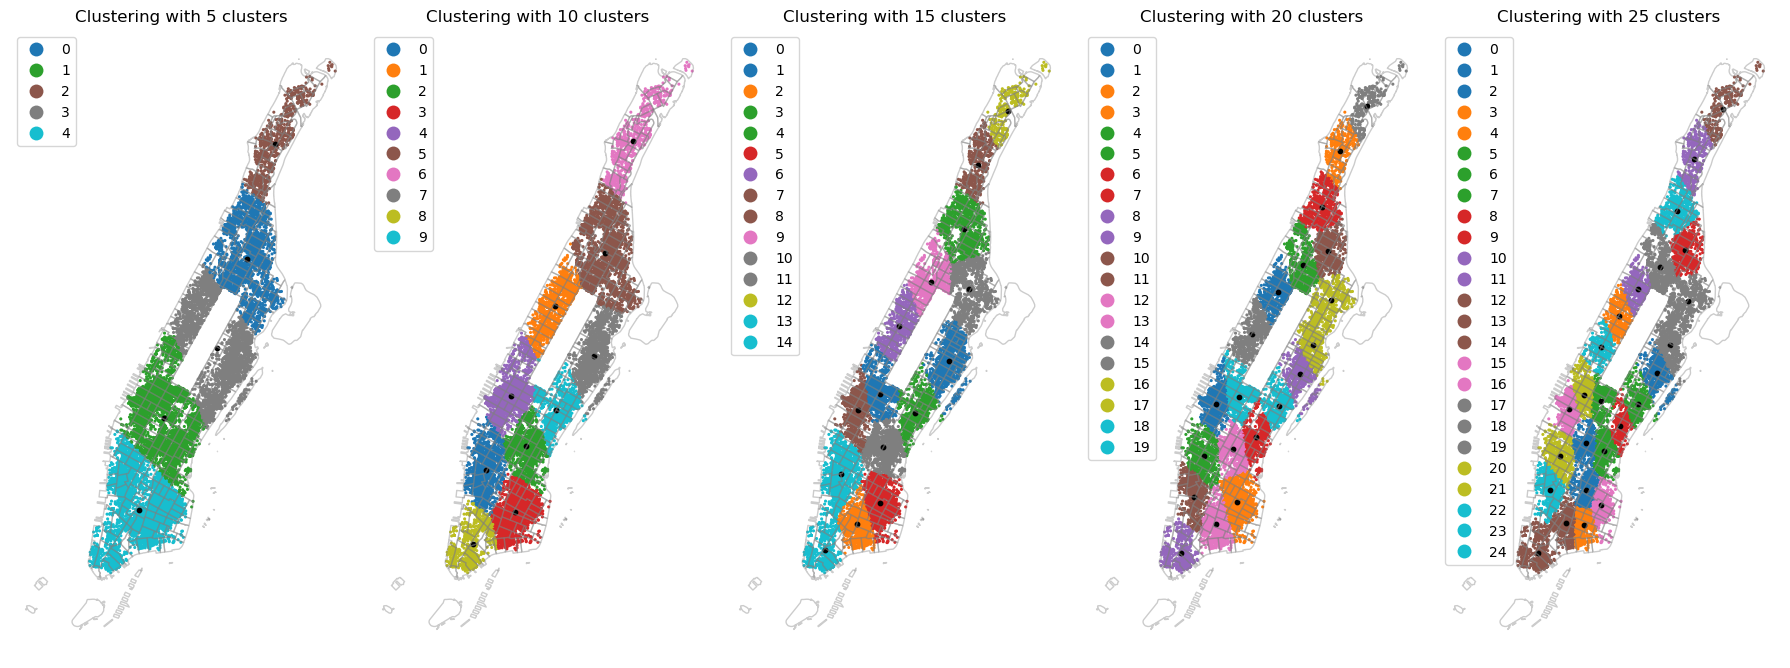

In [82]:
# Create a figure with 4 subplots
fig, axs = plt.subplots(1, 5, figsize=(18, 18))

# Call the function for different values of k and add to subplots
for i, k in enumerate([5, 10, 15, 20, 25]):
    find_cluster(listing, k, axs[i % 5])

plt.tight_layout()
plt.show()

Compare the 6 clustering results. How do you interpret any discrepancies among them? How does the number of clusters influence the results? Also, discuss the implications of these results for future analyses that use the K-means algorithm. (2 pts)

Use markdown to write your answer.

As the value of k increases, there are more groups and each of the data is on average closer to the centroid of its cluster. Having more groups gives more granularity for data analysis, but we can also lose the bigger picture if we split the data into too many groups. For example, when k=5 each of the cluster can give us information on very big geographical areas (downtown, midtown, uptown), while when when k=20 the information we can gain from each cluster is more on the neighborhood level.

### 2.2  Density-based Clustering Algorithm (DBSCAN) (18 pts)
Next, you will use DBSCAN algorithm to the same listing dataset and explore the difference between DBSCAN and K-means.

To conduct DBSCAN, you first need to specify `eps` and `min_samples` parameters. `eps` refers to the maximum distance between two samples for one to be considered as in the neighborhood of the other in radians rather than kilometers. Use the given equation to transform 8 kilometers into radians. 

`min_samples` refers to the number of samples (or total weight) in a neighborhood for a point to be considered as a core point. You will use 20 listings in this exercise as the minimum number of samples. (2 pts)

Hint: more details on DBSCAN can be found in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). 

In [84]:
import pointpats
from sklearn.cluster import DBSCAN
import seaborn

# def find_clusters(listing, eps_km, weights = None, name = None):
km = 8
epsilon = km / 6371.0088
minp = 20

In [144]:
listing['price'].describe()

count    10452.000000
mean       269.057788
std        610.596690
min         10.000000
25%        105.000000
50%        160.000000
75%        276.000000
max      20500.000000
Name: price, dtype: float64

Use `epsilon` and `minp` in the previous step for the DBSCAN function. Specify sample weight as the `price` in listing. Next, add the cluster labels to listing as a new column `lbls`. (2 pts)

In [191]:
# insert your code here
clusterer = DBSCAN(eps=epsilon, min_samples=minp)

#there are null values so I replace them with the mean
# clusterer.fit(listing[["price"]].fillna(listing["price"].mean()))
prices_nonnull = listing["price"].fillna(listing["price"].mean())
clusterer.fit(listing[["longitude", "latitude"]], sample_weight=prices_nonnull*0.005)

DBSCAN(eps=0.001255688110178093, min_samples=20)

In [192]:
#add cluster labels to listing as a new column
lbls = pd.Series(clusterer.labels_, index=listing.index)
listing['lbls'] = lbls

How many clusters have been classified? (2 pts)

In [187]:
lbls.value_counts()

-1     13820
 7       431
 2       350
 0       298
 9       283
 10      264
 5       261
 6       238
 1       227
 3       178
 12      161
 11      139
 8       125
 4       119
 14      108
 15       83
 13       75
Name: count, dtype: int64

In [193]:
#-1 means indicates that a point is not in a cluster, so the total clusters is len-1
print(len (lbls.value_counts())-1, "clusters have been classified")


36 clusters have been classified


In [194]:
# insert your code here
listing["DBSCAN_label"] = clusterer.labels_

c:\Users\desai\miniforge3\envs\crp4680\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


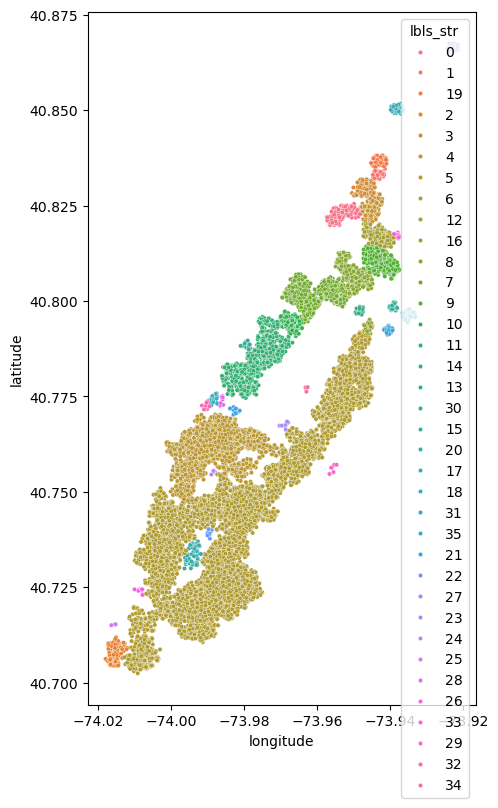

In [195]:
f, ax = plt.subplots(1, figsize=(5, 9))

# noise = listing.loc[lbls == -1]
# noise.plot(ax=ax, color="grey", markersize = 5)

datapts = listing.loc[lbls != -1]
datapts["lbls_str"] = datapts["lbls"].astype(str)
seaborn.scatterplot(data=datapts, x="longitude", y="latitude", hue="lbls_str", ax=ax, s=10)

plt.show()

Plot the clustering results. Please include:
- The unclassified points (noise) in grey and size as 5. (2 pts)
- The clustered points in different colors and size as 10 (hint: check the [seaborn.scatterplot documentation](https://seaborn.pydata.org/generated/seaborn.scatterplot.html) and specify parameter *hue* as `lbls`). Make sure to turn `lbls` into strings so that they are not read as continuous variables (2 pts)
- Base map and title. (2 pts)

In [ ]:
# insert your code here

Try a different `epsilon` with everything else the same. Plot your results in the same format. (2 pts)

Compare the two DBSCAN results obtained using different epsilon values and determine which one is a better reflection of the neighborhoods in Manhattan. Discuss the implications of your findings for future DBSCAN analyses. (2 pts) Use a markdown for your answer.

Compare the clustering results obtained in section 2.1 and 2.2. List several pros and cons of the two K-Means implementation methods. (2 pts) Use a markdown for your answer.